In [1]:
using DifferentialEquations, Random, Lux, ComponentArrays, Optimization, OptimizationOptimJL, DiffEqFlux, Plots

In [2]:
N_days = 25  # Duration of the simulation (in days)
const S0 = 1.0  # Total population (normalized to 1.0)
u0 = [S0 * 0.99, S0 * 0.01, 0.0]  # Initial conditions: [Susceptible, Infected, Recovered]

# True infection and recovery rates (used for synthetic data generation)
p0 = [0.85, 0.1]  # [τSI (infection rate), τIR (recovery rate)]

tspan = (0.0, Float64(N_days))  # Time range for simulation
t = range(tspan[1], tspan[2], length=N_days)  # Time points for evaluation

0.0:1.0416666666666667:25.0

In [3]:
# Define the classic SIR model as an ODE
function SIR!(du, u, p, t)
    (S, I, R) = u
    (τSI, τIR) = abs.(p)  # Ensure parameters are non-negative

    du[1] = -τSI*S*I  # dS/dt = ?
    du[2] = τSI*S*I - τIR*I  # dI/dt = ?
    du[3] = τIR*I  # dR/dt = ?
end

# Solve the ODE to generate synthetic data
prob = ODEProblem(SIR!, u0, tspan, p0)
true_sol = Array(solve(prob, Tsit5(), saveat=t))  # Solve using appropriate solver

3×25 Matrix{Float64}:
 0.99  0.976892    0.949479    0.894899   …  0.000901039  0.000777252
 0.01  0.0215397   0.0456042   0.0932196     0.175293     0.15807
 0.0   0.00156808  0.00491663  0.0118818     0.823806     0.841153

In [4]:
# ============================
# 2. Constructing the UDE Model (Neural Network-driven SIR Model)
# ============================
rng = Random.default_rng()  # Random number generator for reproducibility

# Define two neural networks to learn infection and recovery rates
NN_SI = Lux.Chain(Lux.Dense(2, 10, relu), Lux.Dense(10, 1))  # Neural network for τSI
NN_IR = Lux.Chain(Lux.Dense(1, 10, relu), Lux.Dense(10, 1))  # Neural network for τIR

# Initialize neural network parameters
p1, st1 = Lux.setup(rng, NN_SI)
p2, st2 = Lux.setup(rng, NN_IR)

# Store all NN parameters in a structured format
p0_vec = (layer_1 = p1, layer_2 = p2)
p0_vec = ComponentArray(p0_vec)  # Convert to ComponentArray for optimization

# Define a softplus activation function to ensure non-negative outputs
function softplus(x)
    return log(1 + exp(x))
end

# Define the SIR Universal Differential Equation (UDE) model
function SIR_UDE!(du, u, p, t)
    (S, I, R) = u  # Extract S, I, R

    # Compute dynamic parameters using neural networks
    NNSI, _ = NN_SI([S, I], p.layer_1, st1)  # Predict τSI using NN_SI
    NNIR, _ = NN_IR([I], p.layer_2, st2)  # Predict τIR using NN_IR

    # Convert outputs to positive and stable values
    τSI = clamp(softplus(NNSI[1]), 10e-5, 1)  # Clamp τSI between min and max
    τIR = clamp(softplus(NNIR[1]), 10e-5, 1)  # Clamp τIR between min and max

    # Define UDE dynamics
    du[1] = -τSI*S*I
    du[2] = τSI*S*I-τIR*I
    du[3] = τIR*I
end

# Define the UDE problem
ude_prob = ODEProblem(SIR_UDE!, u0, tspan, p0_vec)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
Non-trivial mass matrix: false
timespan: (0.0, 25.0)
u0: 3-element Vector{Float64}:
 0.99
 0.01
 0.0

In [5]:
# ============================
# 3. Define Loss Function for Training
# ============================
function loss_function(p)
    sol = solve(ude_prob, Tsit5(), u0=u0, p=p, saveat=t, sensealg=QuadratureAdjoint())
    
    # Handle numerical instabilities
    if any(x -> any(isnan, x), sol.u) || length(sol.t) != length(t)
        return Inf  # Penalize unstable solutions
    end
    
    return sum(abs2, sol[2, :] .- true_sol[2, :])  # Mean Squared Error on infected cases (I)
end

loss_function (generic function with 1 method)

In [10]:
# ============================
# 4. Training the Model using LBFGS Optimizer
# ============================
opt_func = OptimizationFunction((x, p) -> loss_function(x), Optimization.AutoZygote())
opt_prob = OptimizationProblem(opt_func, p0_vec)
trained_params = solve(opt_prob, OptimizationOptimJL.LBFGS(); maxiters=20)  # Train for given iterations

retcode: Failure
u: ComponentVector{Float32}(layer_1 = (layer_1 = (weight = Float32[1.015362 -0.69625497; -2.1612737 2.0362093; … ; -0.0032675017 -0.50298035; 2.0524602 -1.234659], bias = Float32[0.43931225, -0.12502144, -0.47018746, 0.12986769, -0.5493381, -0.4132737, -0.10101755, 0.0010575111, -0.7029685, 0.14580126]), layer_2 = (weight = Float32[-0.054511867 0.3127481 … 0.11446584 0.52593726], bias = Float32[0.029867081])), layer_2 = (layer_1 = (weight = Float32[1.7286459; -2.012776; … ; -3.3248703; 0.9916132;;], bias = Float32[-0.13359475, -0.11156142, -0.7360252, -0.105431795, -0.8902627, 0.807653, 0.29770908, -0.21888351, -0.9181559, -0.69542474]), layer_2 = (weight = Float32[-1.0294799 0.1280896 … 0.14575994 0.02158178], bias = Float32[-1.0036424])))

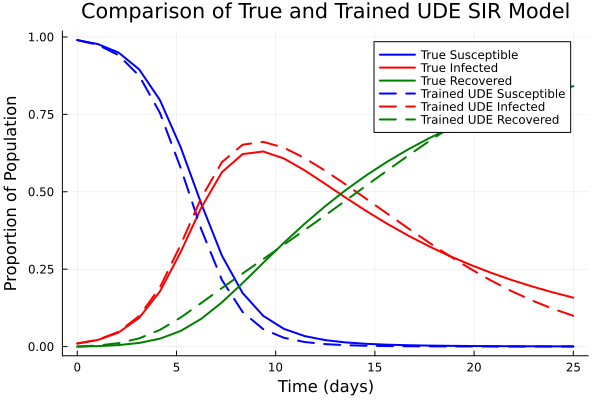

In [11]:
# ============================
# 5. Solve with Trained Parameters and Compare Results
# ============================
trained_sol = solve(ude_prob, Tsit5(), p=trained_params.u, saveat=t)

plot(t, true_sol[1, :], label="True Susceptible", linewidth=2, color=:blue)
plot!(t, true_sol[2, :], label="True Infected", linewidth=2, color=:red)
plot!(t, true_sol[3, :], label="True Recovered", linewidth=2, color=:green)

plot!(t, trained_sol[1, :], label="Trained UDE Susceptible", linewidth=2, linestyle=:dash, color=:blue)
plot!(t, trained_sol[2, :], label="Trained UDE Infected", linewidth=2, linestyle=:dash, color=:red)
plot!(t, trained_sol[3, :], label="Trained UDE Recovered", linewidth=2, linestyle=:dash, color=:green)

xlabel!("Time (days)")
ylabel!("Proportion of Population")
title!("Comparison of True and Trained UDE SIR Model")

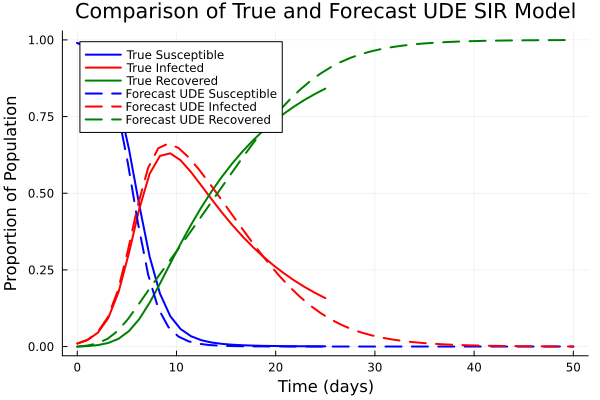

In [12]:
# ============================
# 6. Extrapolate (forecast to 50 days)
# ============================

N_days2 = 50  # Duration of the simulation (in days)

tspan2 = (0.0, Float64(N_days2))  # Time range for simulation
t2 = range(tspan2[1], tspan2[2], length=N_days2)  # Time points for evaluation

ude_prob2 = ODEProblem(SIR_UDE!, u0, tspan2, p0_vec)

trained_sol2 = solve(ude_prob2, Tsit5(), p=trained_params.u, saveat=t2)

plot(t, true_sol[1, :], label="True Susceptible", linewidth=2, color=:blue)
plot!(t, true_sol[2, :], label="True Infected", linewidth=2, color=:red)
plot!(t, true_sol[3, :], label="True Recovered", linewidth=2, color=:green)

plot!(t2, trained_sol2[1, :], label="Forecast UDE Susceptible", linewidth=2, linestyle=:dash, color=:blue)
plot!(t2, trained_sol2[2, :], label="Forecast UDE Infected", linewidth=2, linestyle=:dash, color=:red)
plot!(t2, trained_sol2[3, :], label="Forecast UDE Recovered", linewidth=2, linestyle=:dash, color=:green)

xlabel!("Time (days)")
ylabel!("Proportion of Population")
title!("Comparison of True and Forecast UDE SIR Model")